# Model AR Testing

Produce simple autoregressive models for our four basic label types

In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath
from pathlib import Path
from functools import partial, reduce
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fname = 'model_test.ipynb'      # FILL
dir_name = 'model'              # FILL
fix_path(get_cwd(fname, dir_name +sep))

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from torch.utils.data import TensorDataset, DataLoader
from dask import delayed, compute
import matplotlib.pyplot as plt

from ipywidgets import interact, interact_manual, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option('display.max_columns', 50)

from common_util import RECON_DIR, JSON_SFX_LEN, DT_CAL_DAILY_FREQ, is_type, pd_common_idx_rows, remove_dups_list, set_loglevel, chained_filter, get_variants, dump_df, load_json, gb_transpose, np_inner, pd_common_index_rows, filter_cols_below, inner_join, outer_join, ser_shift, list_get_dict, window_iter, benchmark
from common_util import isnt, midx_get_level, midx_intersect, str_to_list, pd_common_idx_rows, midx_split, pd_midx_to_arr, window_iter, np_is_ndim, get_class_name, get0
from model.common import DATASET_DIR, HOPT_WORKER_BIN, default_model, default_backend, default_dataset, default_trials_count
from model.data_util import datagen, align_first_last_cols, prune_nulls, prepare_transpose_data, prepare_label_data, prepare_target_data
from model.model_util import CLF_MAP, REG_MAP
from recon.dataset_util import prep_dataset, gen_group
from recon.split_util import get_train_test_split, gen_time_series_split, index_three_split, pd_binary_clip

Using TensorFlow backend.


In [2]:
set_loglevel('info')

### List Datasets

In [3]:
os.listdir(DATASET_DIR)

['mvp_targets_eod2.json',
 'mvp_dnorm_raw.json',
 'mvp_targets_fbxeod1_log.json',
 'drl.json',
 'mvp_labels.json',
 'mvp_labels_fbxeod2.json',
 'dnorm_raw_pba_ohlca.json',
 'mvp_targets.json',
 'mvp_targets_eod1_lin.json',
 'mvp_labels_fbxeod1_lin.json',
 'dma.json',
 'mvp_labels_fbxeod1_log.json',
 'dnorm_raw.json',
 'mvp_labels_eod1_log.json',
 'mvp_targets_eod1_log.json',
 'raw_pba_ohlca.json',
 'row_masks.json',
 'mvp_labels_eod2.json',
 'ddiff.json',
 'dnorm_sym.json',
 'mvp_targets_fbxeod2.json',
 'mvp_labels_eod1_lin.json',
 'sym_raw.json',
 'mvp_targets_fbxeod1_lin.json',
 'xg0_reteod_direod.json',
 'dnorm_dmx_raw_pba_ohlca.json']

### Set Fixed Experiment Parameters ("Commandline" Arguments)

In [4]:
logdir = None
cmd_input = {
    'model=': 'TCN',
    'backend=': 'pytorch',
    'assets=': 'sp_500', # 'russell_2000'
    'trials_count=': 50,
}
mod_type = 'clf'

In [5]:
model_code = cmd_input['model='] if (cmd_input['model='] is not None) else default_model
backend_name = cmd_input['backend='] if (cmd_input['backend='] is not None) else default_backend
# dataset_fname = cmd_input['dataset='] if (cmd_input['dataset='] is not None) else default_dataset
assets = str_to_list(cmd_input['assets=']) if (cmd_input['assets='] is not None) else None
trials_count = int(cmd_input['trials_count=']) if (cmd_input['trials_count='] is not None) else default_trials_count

In [6]:
mod_obj = CLF_MAP[backend_name][model_code]() if (mod_type == 'reg') else CLF_MAP[backend_name][model_code]()
mod_name = get_class_name(mod_obj)

In [7]:
logging.info('model: {}'.format(mod_name))
logging.info('backend: {}'.format(backend_name))
logging.info('assets: {}'.format(str('all' if (assets==None) else ', '.join(assets))))

INFO:root:model: TCN_CLF
INFO:root:backend: pytorch
INFO:root:assets: sp_500


### Load Labels / Targets

In [8]:
dataset_type = ''
label_dataset = prep_dataset({'labels': 'mvp_labels{}.json'.format(dataset_type)}, assets=assets, filters_map=None)
target_dataset = prep_dataset({'targets': 'mvp_targets{}.json'.format(dataset_type)}, assets=assets, filters_map=None)

In [9]:
label_ser = reduce(lambda a,b: inner_join(a, b), [v.rename(columns=lambda _: k[-1]).compute() for k, v in label_dataset['labels']['dfs']]).dropna().sum(axis=1)
target_ser = target_dataset['targets']['dfs'][list(target_dataset['targets']['dfs'].keys())[0]].dropna().compute().squeeze()
if (mod_type == 'clf'):
    label_ser = label_ser.loc[label_ser!=0]
    target_ser = target_ser.loc[target_ser!=0]

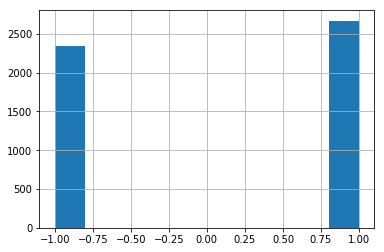

In [10]:
label_ser.hist()

In [11]:
pos_l, neg_l = pd_binary_clip(label_ser) # Clip Label by Side

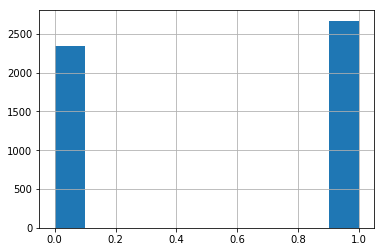

In [12]:
pos_l.hist()

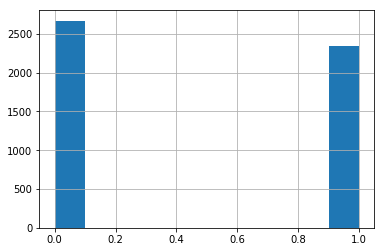

In [13]:
neg_l.hist()

### Set Device

In [14]:
dev = torch.device('cuda') if (torch.cuda.is_available()) else torch.device('cpu')

### Split Data into Ndarrays

In [15]:
if (mod_type == 'clf'):
    f, l, t = pd_common_idx_rows(target_ser, ser_shift(pos_l, cast_type=int), target_ser)
#     l[l==-1] = 0
    assert(f.size==l.size==t.size)
elif (mod_type == 'reg'):
    f, l, t = pd_common_idx_rows(target_ser, ser_shift(target_ser), ser_shift(target_ser))
    assert(f.size==l.size==t.size)

In [16]:
val_ratio = .2
test_ratio = .2
train_ratio = 1-(val_ratio+test_ratio)
f_train_idx, f_val_idx, f_test_idx = midx_split(f.index, train_ratio, val_ratio, test_ratio)
l_train_idx, l_val_idx, l_test_idx = midx_split(l.index, train_ratio, val_ratio, test_ratio)
t_train_idx, t_val_idx, t_test_idx = midx_split(t.index, train_ratio, val_ratio, test_ratio)

In [17]:
f_train_pd, f_val_pd, f_test_pd = f.loc[f_train_idx], f.loc[f_val_idx], f.loc[f_test_idx]
l_train_pd, l_val_pd, l_test_pd = l.loc[l_train_idx], l.loc[l_val_idx], l.loc[l_test_idx]
t_train_pd, t_val_pd, t_test_pd = t.loc[t_train_idx], t.loc[t_val_idx], t.loc[t_test_idx]

In [18]:
if (is_type(f.index, pd.core.index.MultiIndex)):
    f_train_np, f_val_np, f_test_np = map(pd_midx_to_arr, [f_train_pd.stack(), f_val_pd.stack(), f_test_pd.stack()])
else:
    f_train_np, f_val_np, f_test_np = f_train_pd.values, f_val_pd.values, f_test_pd.values
l_train_np, l_val_np, l_test_np = l_train_pd.values, l_val_pd.values, l_test_pd.values
t_train_np, t_val_np, t_test_np = t_train_pd.values, t_val_pd.values, t_test_pd.values

In [19]:
val_tar = torch.tensor(t_val_np, dtype=torch.float32, device=dev, requires_grad=False).squeeze()

In [20]:
input_shape = mod_obj.get_obs_shape(f_train_np.shape)
print(f_train_np.shape)
print(input_shape)

(3005,)
(1, 1)


### Model

### Hyperparameter List

In [25]:
mod_obj.get_space()

{'epochs': <hyperopt.pyll.base.Apply at 0x7fe757254940>,
 'batch_size': <hyperopt.pyll.base.Apply at 0x7fe757254a58>,
 'loss': <hyperopt.pyll.base.Apply at 0x7fe7572544a8>,
 'opt': <hyperopt.pyll.base.Apply at 0x7fe757254748>,
 'input_windows': <hyperopt.pyll.base.Apply at 0x7fe7ec69bf98>,
 'topology': <hyperopt.pyll.base.Apply at 0x7fe7ec687208>,
 'kernel_size': <hyperopt.pyll.base.Apply at 0x7fe757254240>,
 'dropout': <hyperopt.pyll.base.Apply at 0x7fe757254390>,
 'attention': False,
 'max_attn_len': 120}

### Set Hyperparameters

In [26]:
# pmf = list(reversed(l_train_pd.value_counts(normalize=True)))

In [22]:
params = {
    'epochs': 500,
    'batch_size': 128, #256
    'loss': 'mae' if (mod_type == 'reg') else 'nll',
#     'cw': pmf,
    'cw': None,
    'opt': {
        'name': 'Adam',
        'lr': .0001
    },
    'input_windows': 20,
    'topology': [5],
    'kernel_size': 10,
    'dropout': 0.05,
    'attention': False,
    'max_attn_len': 80
}

### Set Data

In [23]:
train_data = (np.expand_dims(f_train_np, 1), l_train_np)
val_data = (np.expand_dims(f_val_np, 1), l_val_np)

In [30]:
X, y = mod_obj.preproc(params, train_data)
print(X.shape)
print(y.shape)

(2986, 1, 20)
(2986, 1)


NameError: name 'params' is not defined

### Define Batch Loss Compute Function

In [178]:
def bloss(params, model, loss_function, feat_batch, lab_batch, optimizer=None, ret_train_pred=False, metrics_fns=mod_obj.metrics_fns):
    """
    Compute loss and metrics on batch, run optimizer on losses if passed.
    """
    # logging.debug('batch tensor[0][0]: {}'.format(feat_batch[0][0]))
    outputs_batch = model(feat_batch)
    loss = loss_function(outputs_batch, lab_batch)
    max_batch, pred_batch = torch.max(outputs_batch, dim=1) # Convert network outputs into predictions
    lab_batch_cpu = lab_batch.cpu()
    pred_batch_cpu = pred_batch.cpu()
    metrics = {name: fn(lab_batch_cpu, pred_batch_cpu) for name, fn in metrics_fns.items()}

    if (optimizer is not None):
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (not ret_train_pred):
            return loss.item(), len(feat_batch), metrics

#     logging.debug('batch loss:   {}'.format(loss.item()))
    return loss.item(), len(feat_batch), metrics, (max_batch.exp(), pred_batch.float())

### Make and Fit Model

In [179]:
# Make Model, Loss Fn, and Optimizer
mdl = mod_obj.get_model(params, input_shape, 1 if (mod_type == 'reg') else 2).to(device=dev)
loss_fn = mod_obj.make_loss_fn(params).to(dev)
opt = mod_obj.make_optimizer(params, mdl.parameters())
display(mdl)

TCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(1, 100, kernel_size=(10,), stride=(1,), padding=(9,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.05)
        (conv2): Conv1d(100, 100, kernel_size=(10,), stride=(1,), padding=(9,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.05)
        (net): Sequential(
          (0): Conv1d(1, 100, kernel_size=(10,), stride=(1,), padding=(9,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.05)
          (4): Conv1d(100, 100, kernel_size=(10,), stride=(1,), padding=(9,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.05)
        )
        (downsample): Conv1d(1, 100, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
    )
  )
  (out): Linear(in_features=100, out_features=2, bias=True)
  (logprob): LogSoftmax()
)

### Run Model

In [180]:
writer = self.tbx(params, logdir) if (logdir is not None) else None
mdl.zero_grad()
opt.zero_grad()

# Metrics
history = {
    'loss': [],
    'val_loss': []
}
for name in mod_obj.metrics_fns.keys():
    history[name] = []
    history['val_{}'.format(name)] = []

# Fit Model
try:
    for epoch in range(params['epochs']):
        epoch_str = str(epoch).zfill(3)

        mdl.train()
        losses, nums, metrics = zip(*[bloss(params, mdl, loss_fn, Xb, yb, optimizer=opt) for Xb, yb in mod_obj.batchify(params, mod_obj.preproc(params, train_data), dev, shuffle_batches=True)])
        loss = np_inner(losses, nums)
        soa = {name[0]: tuple(d[name[0]] for d in metrics) for name in zip(*metrics)}
        metric = {name: np_inner(vals, nums) for name, vals in soa.items()}
        history['loss'].append(loss)
        for name, val in metric.items():
            history[name].append(val)

        mdl.eval()
        with torch.no_grad():
            Xe, ye = get0(*mod_obj.batchify(params, mod_obj.preproc(params, val_data), dev, override_batch_size=val_data[-1].size, shuffle_batches=False))
            loss, num, metric, pred = bloss(params, mdl, loss_fn, Xe, ye)
            pred_conf, pred_dir = pred
        history['val_loss'].append(loss)
        for name, val in metric.items():
            history['val_{}'.format(name)].append(val)

    results = {
#         'history': history,
        'mean': {name: np.mean(vals) for name, vals in history.items()},
        'last': {name: vals[-1] for name, vals in history.items()}
    }

except Exception as e:
    logging.error('Error during model fitting: {}'.format(str(e)))
    raise e

### Results

In [181]:
if (mod_type == 'clf'):
    train_range = l_train_pd.value_counts(normalize=True, sort=True, ascending=True).values
    val_range = l_val_pd.value_counts(normalize=True, sort=True, ascending=True).values
    display('      #0         #1')
    display('train {}'.format(train_range))
    display('val {}'.format(val_range))

'      #0         #1'

'train [0.47354409 0.52645591]'

'val [0.44755245 0.55244755]'

In [182]:
results['last']

{'loss': 0.6823490974652392,
 'val_loss': 0.6921223998069763,
 'acc': 0.5421969189551239,
 'val_acc': 0.5427698574338086}

In [183]:
vt = val_tar[val_tar.size()[0]-pred_dir.size()[0]:]

In [184]:
pred_dir @ vt

tensor(-0.2005, device='cuda:0')

In [185]:
(pred_conf * pred_dir) @ vt

tensor(-0.1775, device='cuda:0')

In [186]:
vt.sum()

tensor(0.5733, device='cuda:0')

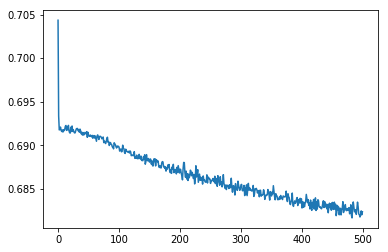

In [187]:
plt.plot(history['loss'])

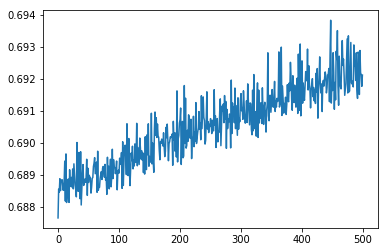

In [188]:
plt.plot(history['val_loss'])